Optimization success: True
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Objective function value: 441.4039334975611
Number of function evaluations: 536
Number of Jacobian evaluations: 67
Optimization status code: 0
Angle IN Solution: 9.819136513521137 degrees
Angle OUT Solution: 85.0 degrees
Force Normal IN Solution: 14.707144679481697 N
Force Normal OUT Solution: 42.086533814589146 N
Force Location Solution: 0.1266637119124817 m
Length Solution: 0.3 m
Width Solution: 0.0005 m
Height Solution: 0.001 m


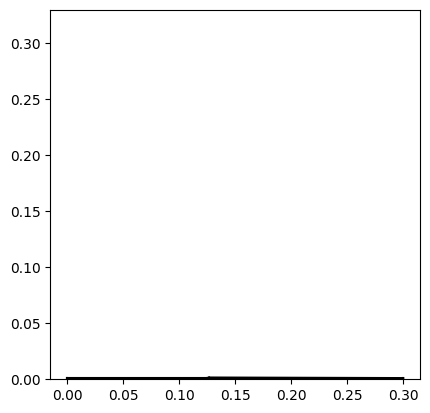

In [12]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

# Define your equations as the objective function (sum of squared residuals)
def objective_in(vars, force_hand_in, force_hand_out, coefficient_friction, elastic_modulus):

    angle_in, angle_out, force_normal_in, force_normal_out, length_beam, width_beam, height_beam = vars

    I_beam = (width_beam * height_beam**3) / 12
    deflection = 0.5 * length_beam

    load_location = length_beam - (deflection / np.tan(angle_in))

    # First equation
    eq1 = (force_hand_in) / (coefficient_friction * np.cos(angle_in) + np.sin(angle_in)) - force_normal_in
    # Second equation
    eq2 = ((3 * elastic_modulus * I_beam) / load_location**3) * deflection - force_normal_in * np.cos(angle_in)

    eq3 = (force_hand_out) / (coefficient_friction * np.cos(angle_out) + np.sin(angle_out)) - force_normal_out
    # Fourth equation
    eq4 = ((3 * elastic_modulus * I_beam) / load_location**3) * deflection - force_normal_out * np.cos(angle_out)

    return eq1**2 + eq2**2 + eq3**2 + eq4**2

# Define constraints between parameters
def constraint(vars):
    angle_in, angle_out, force_normal_in, force_normal_out, length_beam, width_beam, height_beam = vars

    # Example constraint: length must be at least twice the width
    return (length_beam - (length_beam*.1 / np.tan(angle_in))) - 0.1 * length_beam

# Constraints dictionary for minimize
constraints = {'type': 'ineq', 'fun': constraint}

# Function to enforce angle constraints using minimize
def constrained_solve_minimize_in(initial_guess, force_hand_in, force_hand_out, coefficient_friction, elastic_modulus):
    # Bounds for the variables: angle between 0 and pi/2 (0 to 90 degrees in radians)
    bounds = [(np.deg2rad(1), np.deg2rad(85)),  # angle_in
              (np.deg2rad(1), np.deg2rad(85)),  # angle_out
              (None, None),                     # force_normal_in
              (None, None),                     # force_normal_out
              (1e-3, 30e-2),                    # length_beam
              (0.5e-3, 30e-2),                  # width_beam
              (1e-3, 10e-2)]                    # height_beam
    
    # Minimize the objective function with constraints
    result = minimize(
        objective_in,
        initial_guess,
        args=(force_hand_in, force_hand_out, coefficient_friction, elastic_modulus),
        bounds=bounds,
        constraints=constraints,
        method='L-BFGS-B'  # Suitable for bounded problems
    )
    
    # Check if the optimization was successful
    print("Optimization success:", result.success)
    print("Exit message:", result.message)
    print("Objective function value:", result.fun)
    print("Number of function evaluations:", result.nfev)
    print("Number of Jacobian evaluations:", result.njev)
    print("Optimization status code:", result.status)

    return result.x

# Example input parameters
force_hand_in = 22.241
force_hand_out = force_hand_in * 2
coefficient_friction = 0.6
elastic_modulus = 2900e6

# Initial guess for [angle_in, angle_out, force_normal_in, force_normal_out, length_beam, width_beam, height_beam]
initial_guess = [np.deg2rad(5), np.deg2rad(5), 100, 100, 10e-2, 5e-2, 1e-2]  # Initial angles in radians and other variables

# Solve the system with minimize
solution = constrained_solve_minimize_in(initial_guess, force_hand_in, force_hand_out, coefficient_friction, elastic_modulus)
angle_in_solution, angle_out_solution, force_normal_in_solution, force_normal_out_solution, length_solution, width_solution, height_solution = solution

force_location_solution = length_solution - (length_solution * 0.1) / np.tan(angle_in_solution)

# Convert angle to degrees for output
angle_solution_degrees_in = np.degrees(angle_in_solution)
angle_solution_degrees_out = np.degrees(angle_out_solution)

# Display results
print(f"Angle IN Solution: {angle_solution_degrees_in} degrees")
print(f"Angle OUT Solution: {angle_solution_degrees_out} degrees")
print(f"Force Normal IN Solution: {force_normal_in_solution} N")
print(f"Force Normal OUT Solution: {force_normal_out_solution} N")
print(f"Force Location Solution: {force_location_solution} m")
print(f"Length Solution: {length_solution} m")
print(f"Width Solution: {width_solution} m")
print(f"Height Solution: {height_solution} m")

# Plotting the structure
rampup_location = force_location_solution - (length_solution * 0.1) / np.tan(angle_out_solution)

plt.figure()
plt.plot([length_solution, 0], [0, 0], 'black')
plt.plot([0, 0], [0, height_solution], 'black')
plt.plot([length_solution, length_solution], [0, height_solution], 'black')
plt.plot([length_solution, force_location_solution], [height_solution, height_solution + height_solution / 2], 'black')
plt.plot([0, rampup_location], [height_solution, height_solution], 'black')
plt.plot([rampup_location, force_location_solution], [height_solution, height_solution + height_solution / 2], 'black')
plt.axis('square')
plt.show()
